In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import seaborn as sns

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df=pd.read_csv("/Users/xllz/Desktop/GTbootcamp/project_3/datasets/Data_Combined.csv", sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse)

/Users/xllz/anaconda3/envs/pyadv/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2015-01-02 to 2020-08-07
Data columns (total 6 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Yield on U.S. 10 Year Government Bond - %  1461 non-null   float64
 1   S&P 500                                    1410 non-null   float64
 2   NASDAQ 100                                 1410 non-null   float64
 3   Bloomberg Dollar Index                     1455 non-null   float64
 4   Gold Price (Oz.) - USD                     1455 non-null   float64
 5   M2 Money Supply - USD Trillions            1290 non-null   float64
dtypes: float64(6)
memory usage: 79.9 KB


In [4]:
df.head()

,Yield on U.S. 10 Year Government Bond - %,S&P 500,NASDAQ 100,Bloomberg Dollar Index,Gold Price (Oz.) - USD,M2 Money Supply - USD Trillions
Date,,,,,,
2015-01-02,2.1105,2058.20,4230.24,1141.02,1188.39,NaN
2015-01-05,2.0320,2020.58,4160.96,1143.40,1204.86,NaN
2015-01-06,1.9402,2002.61,4110.83,1143.01,1218.58,NaN
2015-01-07,1.9677,2025.90,4160.00,1145.62,1211.41,NaN
2015-01-08,2.0179,2062.14,4240.55,1147.54,1208.79,NaN


Section 1: plot six datasets individually

In [5]:
#drop nans for S&P 500 price
sp500=df['S&P 500']
df_sp500=sp500.dropna()
print(len(df_sp500))

1410


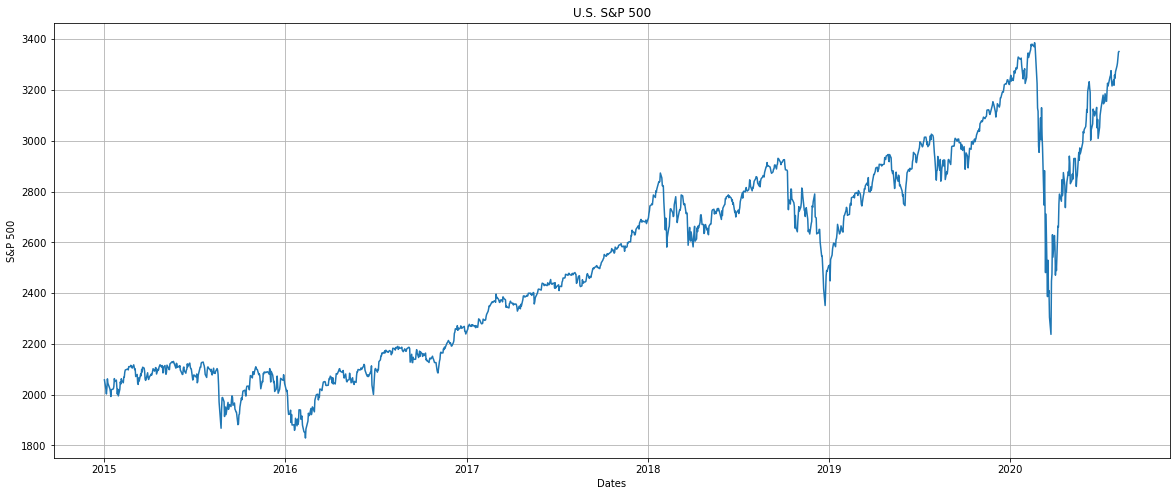

In [6]:
#plot S&P 500 price
plt.figure(figsize=(20,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('S&P 500')
plt.plot(df_sp500)
plt.title('U.S. S&P 500')
plt.show()

In [7]:
#look at NASDAQ 100 price
nasdaq100=df['NASDAQ 100']
df_nasdaq100=nasdaq100.dropna()
print(len(df_nasdaq100))

1410


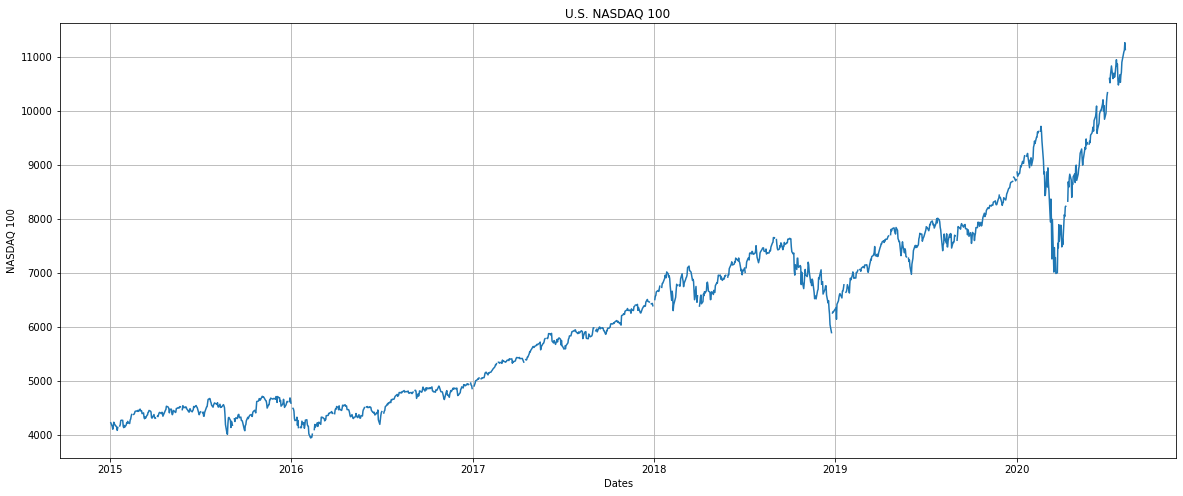

In [8]:
#plot NASDAQ 100 price
plt.figure(figsize=(20,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('NASDAQ 100')
plt.plot(df['NASDAQ 100'])
plt.title('U.S. NASDAQ 100')
plt.show()

1461


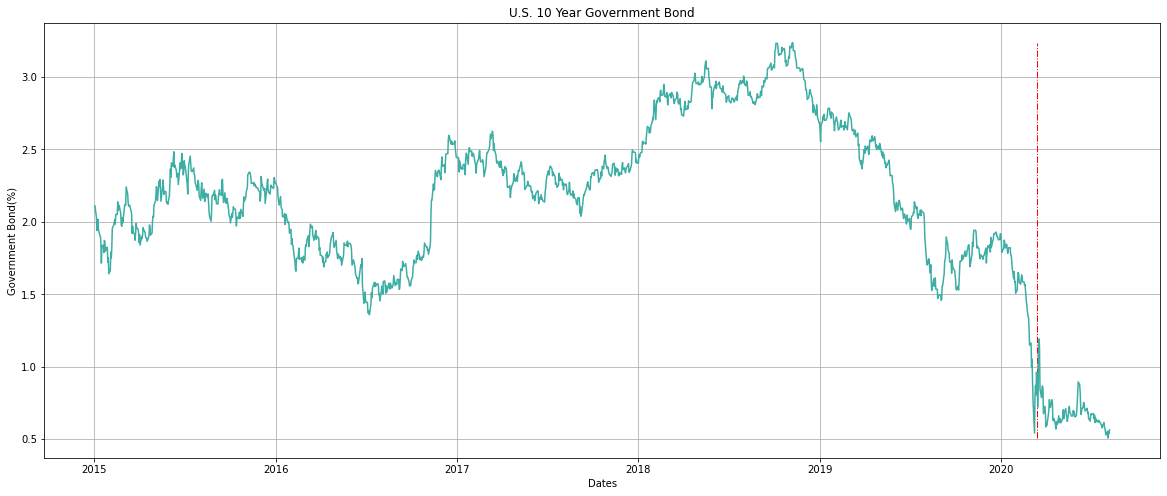

In [9]:
#plot Bond price
bond=df['Yield on U.S. 10 Year Government Bond - %']
df_bond=bond.dropna()
print(len(df_bond))
plt.figure(figsize=(20,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Government Bond(%)')
plt.plot(df_bond, color='#3CAEA3')
plt.title('U.S. 10 Year Government Bond')
ymin=df_bond.min()
ymax=df_bond.max()
plt.vlines(x=['2020-03-13'], ymin=ymin, ymax=ymax, color='r',linewidth=1, linestyle='-.')
plt.savefig('US_10Year_Government_Bond.jpg')
plt.show()

1455


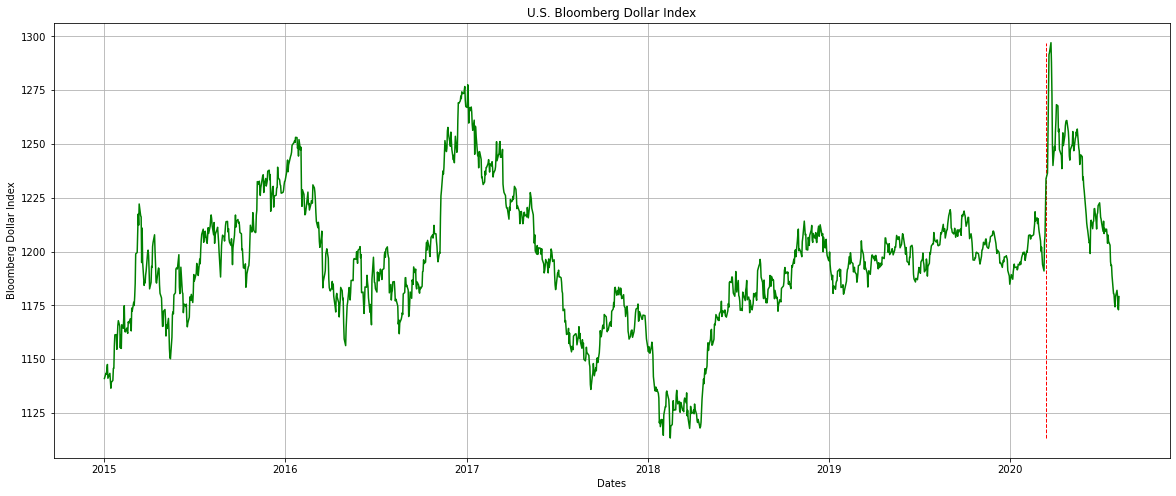

In [10]:
#plot Dollar price
dollar = df['Bloomberg Dollar Index']
df_dollar=dollar.dropna()
print(len(df_dollar))
plt.figure(figsize=(20,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Bloomberg Dollar Index')
plt.plot(df_dollar, color='green')
plt.title('U.S. Bloomberg Dollar Index')
ymin=df_dollar.min()
ymax=df_dollar.max()
plt.vlines(x=['2020-03-13'], ymin=ymin, ymax=ymax, color='r',linewidth=1, linestyle='--')
plt.savefig('US_Bloomberg_Dollar_Index.jpg')
plt.show()

1455


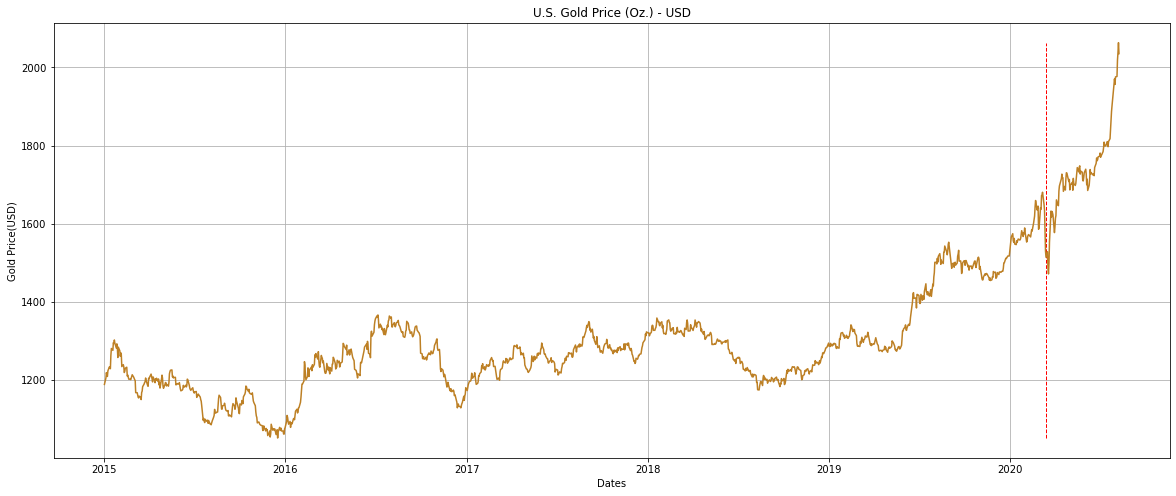

In [11]:
#plot Gold price
gold=df['Gold Price (Oz.) - USD']
df_gold=gold.dropna()
print(len(df_gold))
plt.figure(figsize=(20,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Gold Price(USD)')
plt.plot(df_gold,color='#BD8025')
plt.title('U.S. Gold Price (Oz.) - USD')
ymin=df_gold.min()
ymax=df_gold.max()
plt.vlines(x=['2020-03-13'], ymin=ymin, ymax=ymax, color='r', linewidth=1, linestyle='--')
plt.savefig('US_Gold_Price.jpg')
plt.show()

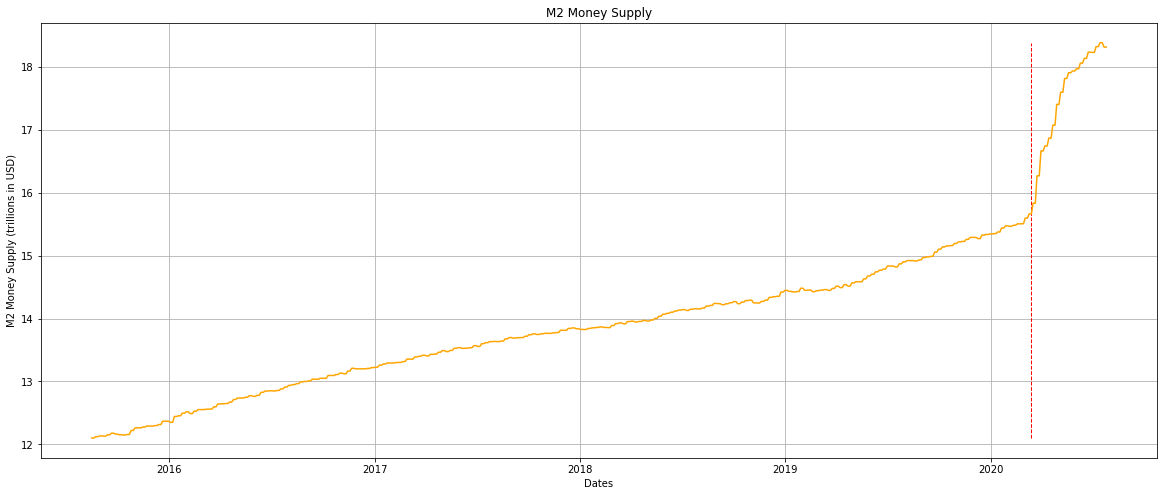

In [12]:
#plot M2
m2=df['M2 Money Supply - USD Trillions']
df_m2=m2.dropna()
plt.figure(figsize=(20,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('M2 Money Supply (trillions in USD)')
plt.plot(df_m2, color='orange')
plt.title('M2 Money Supply')
ymin=df_m2.min()
ymax=df_m2.max()
plt.vlines(x=['2020-03-13'], ymin=ymin, ymax=ymax, color='r', linewidth=1, linestyle='--')
plt.savefig('US_M2_Money_Supply.jpg')
plt.show()

Section 2: Test whether dataset is staionary

In [13]:
#Test for staionarity
#Null Hypothesis: The series has a unit root (value of a =1) or the series is non-stationary
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
#Ref: https://towardsdatascience.com/stock-market-forecasting-using-time-series-c3d21f2dd37f

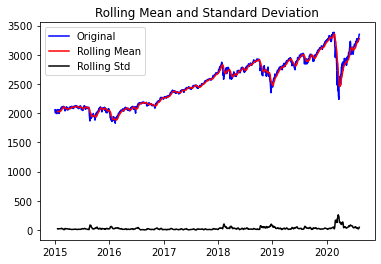

Results of dickey fuller test
Test Statistics                  -0.980544
p-value                           0.760294
No. of lags used                  9.000000
Number of observations used    1400.000000
critical value (1%)              -3.435030
critical value (5%)              -2.863607
critical value (10%)             -2.567870
dtype: float64


In [14]:
test_stationarity(df_sp500)

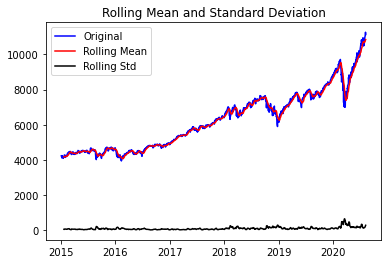

Results of dickey fuller test
Test Statistics                   0.958771
p-value                           0.993811
No. of lags used                  9.000000
Number of observations used    1400.000000
critical value (1%)              -3.435030
critical value (5%)              -2.863607
critical value (10%)             -2.567870
dtype: float64


In [15]:
test_stationarity(df_nasdaq100)

Section 3: use historic data to predict stock price after declaration 

In [16]:
df_sp500.tail()

Date
2020-08-03    3294.61
2020-08-04    3306.51
2020-08-05    3327.77
2020-08-06    3349.16
2020-08-07    3351.28
Name: S&P 500, dtype: float64

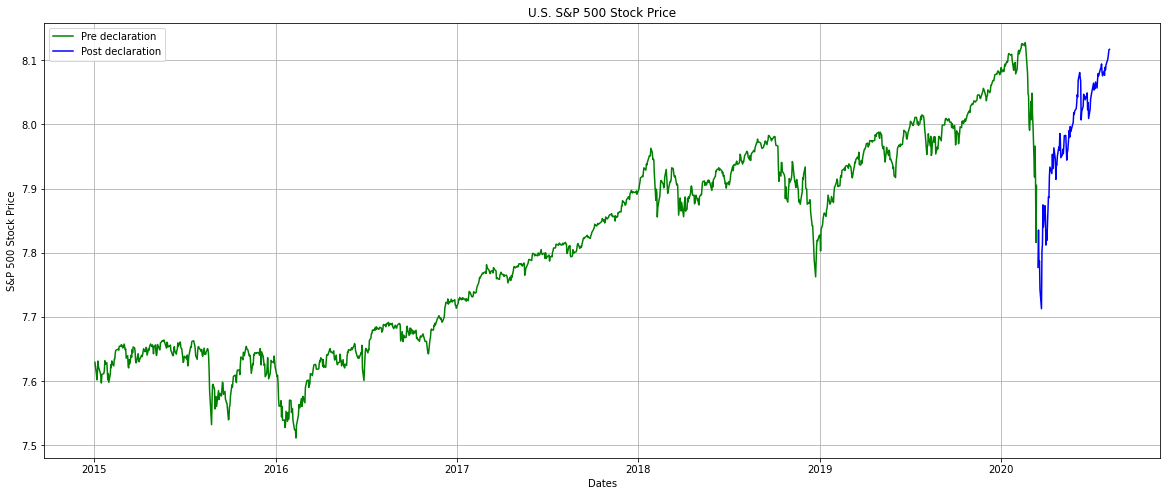

In [17]:
df_log = np.log(df_sp500)
df_log.head()
#split data into train and training set
train_data, test_data = df_log['2015-01-02':'2020-03-13'], df_log['2020-03-14':'2020-08-07']
#train_data.tail()
#test_data.head()
plt.figure(figsize=(20,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('S&P 500 Stock Price')
plt.title('U.S. S&P 500 Stock Price')
plt.plot(train_data, 'green', label='Pre declaration')
plt.plot(test_data, 'blue', label='Post declaration')
plt.legend()

In [18]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8317.249, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8327.202, Time=0.39 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8328.173, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8318.671, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8325.451, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-8327.198, Time=0.97 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8331.201, Time=0.86 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-8344.653, Time=1.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-8326.180, Time=0.88 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-8343.344, Time=1.98 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-8337.308, Time=0.80 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-8336.145, Time=0.66 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-8333.825, Time=0.31 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-8335.512, Time=0.46 sec
 ARIMA(2,1,2)(0,0,0

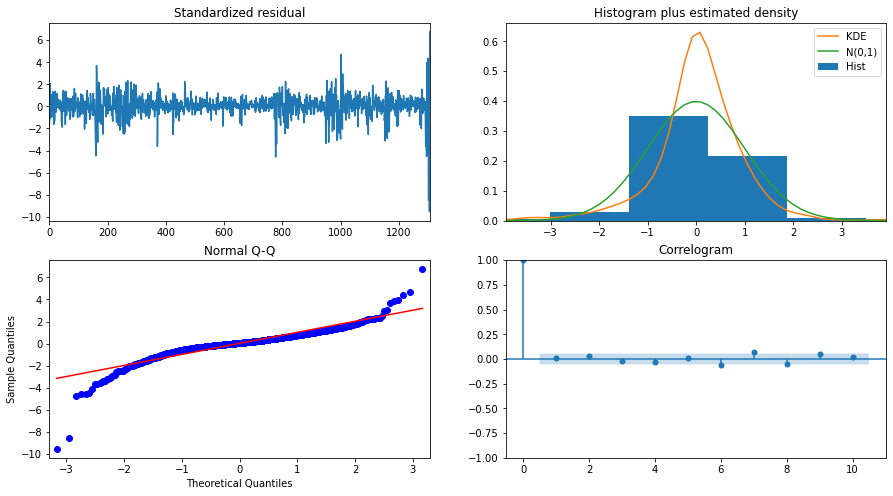

In [19]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.
Top Right: The density plot suggest normal distribution with mean zero.
Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.
Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

In [20]:
model = ARIMA(train_data, order=(2, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

/Users/xllz/anaconda3/envs/pyadv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xllz/anaconda3/envs/pyadv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:              D.S&P 500   No. Observations:                 1307
Model:                 ARIMA(2, 1, 2)   Log Likelihood                4180.392
Method:                       css-mle   S.D. of innovations              0.010
Date:                Sat, 15 Aug 2020   AIC                          -8348.783
Time:                        11:13:28   BIC                          -8317.730
Sample:                             1   HQIC                         -8337.135
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0002      0.000      0.802      0.423      -0.000       0.001
ar.L1.D.S&P 500    -0.6085      0.074     -8.272      0.000      -0.753      -0.464
ar.L2.D.S&P 500    -0.8528      

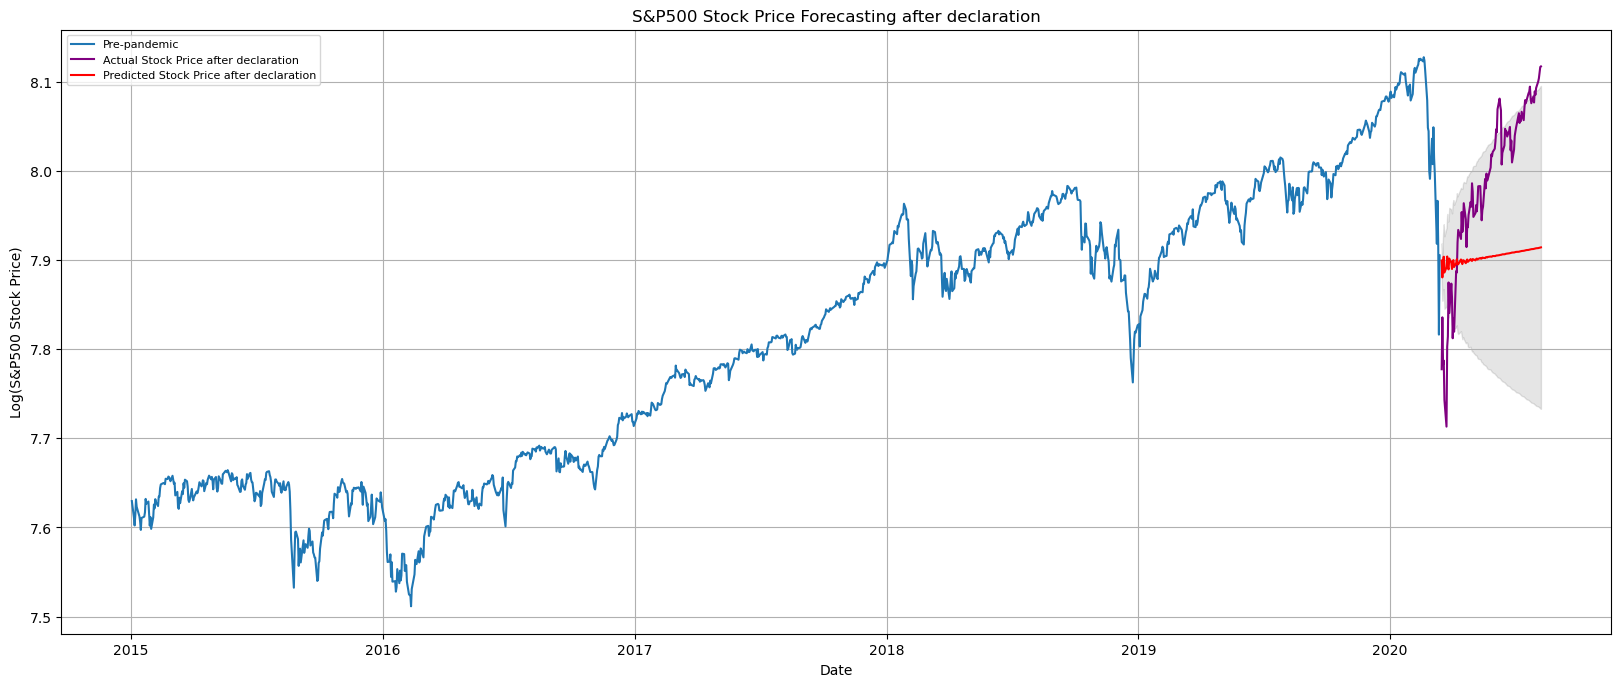

In [21]:
# Forecast
fc, se, conf = fitted.forecast(102, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
fc_series
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(20,8), dpi=100)
plt.grid(True)
plt.plot(train_data, label='Pre-pandemic')
plt.plot(test_data, color = 'purple', label='Actual Stock Price after declaration')
plt.plot(fc_series, color = 'red',label='Predicted Stock Price after declaration')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('S&P500 Stock Price Forecasting after declaration')
plt.xlabel('Date')
plt.ylabel('Log(S&P500 Stock Price)')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('S&P500_Stock_Price_Forecasting1.jpg')
plt.show()

In [22]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.014536025548160953
MAE: 0.10848539874317799
RMSE: 0.12056544093628553
MAPE: 0.013535856325900096


Section 4: use data after declaration to predict stock price for most recent days

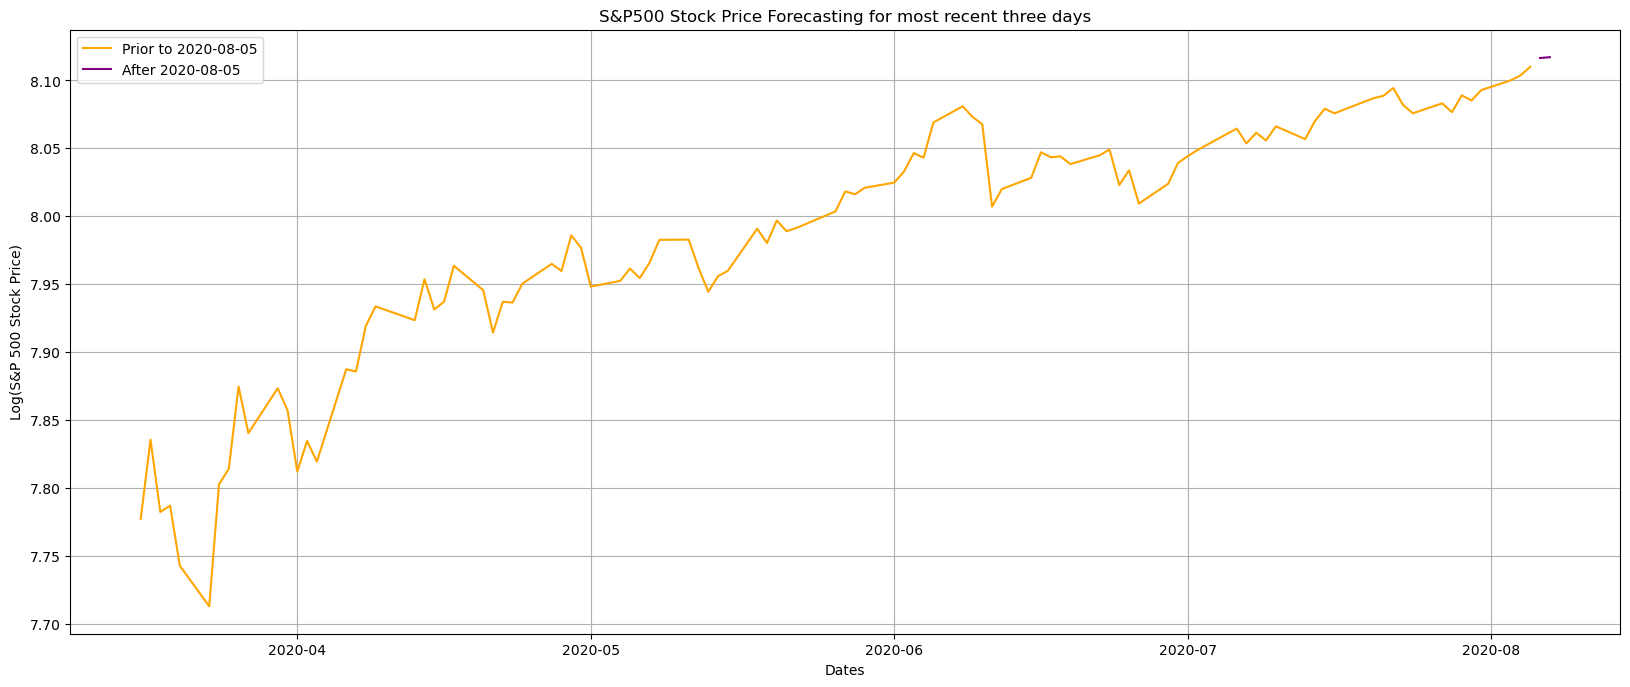

In [23]:
#split data into train and training set
df_log = np.log(df_sp500)
#print(df_log)
train_data, test_data = df_log['2020-03-14':'2020-08-05'], df_log['2020-08-06':'2020-08-07']
# train_data.tail()
# test_data.tail()
plt.figure(figsize=(20,8), dpi=100)
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Log(S&P 500 Stock Price)')
plt.title('S&P500 Stock Price Forecasting for most recent three days')
plt.plot(train_data, 'orange', label='Prior to 2020-08-05')
plt.plot(test_data, 'purple', label='After 2020-08-05')
plt.legend()

In [24]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-467.519, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-472.210, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-471.293, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-467.309, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-471.252, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-471.111, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-472.934, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-478.112, Time=0.29 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-470.696, Time=0.31 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-467.965, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-468.919, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-471.620, Time=0.20 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 2.129 seconds
                               SARIMAX Results                                
Dep. Vari

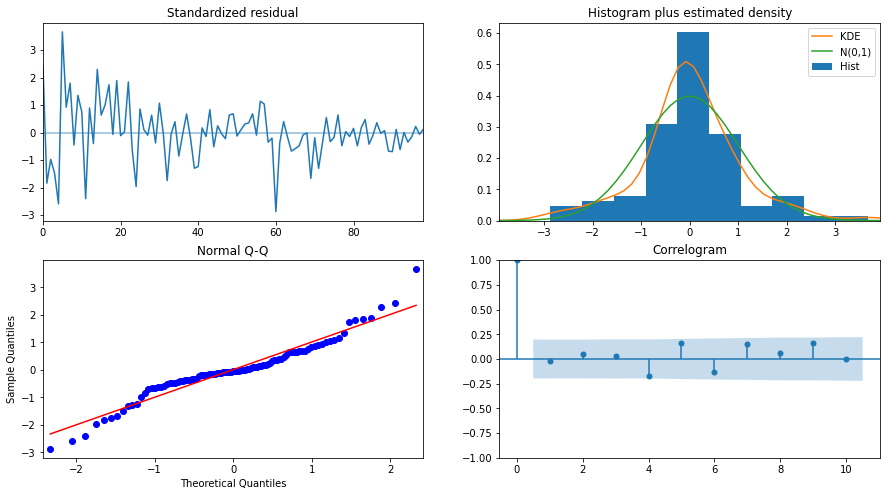

In [25]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [26]:
model = ARIMA(train_data, order=(3, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

/Users/xllz/anaconda3/envs/pyadv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xllz/anaconda3/envs/pyadv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:              D.S&P 500   No. Observations:                   99
Model:                 ARIMA(3, 1, 1)   Log Likelihood                 245.137
Method:                       css-mle   S.D. of innovations              0.020
Date:                Sat, 15 Aug 2020   AIC                           -478.274
Time:                        11:13:33   BIC                           -462.703
Sample:                             1   HQIC                          -471.974
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0033      0.001      3.651      0.000       0.002       0.005
ar.L1.D.S&P 500     0.4049      0.136      2.969      0.003       0.138       0.672
ar.L2.D.S&P 500     0.2026      

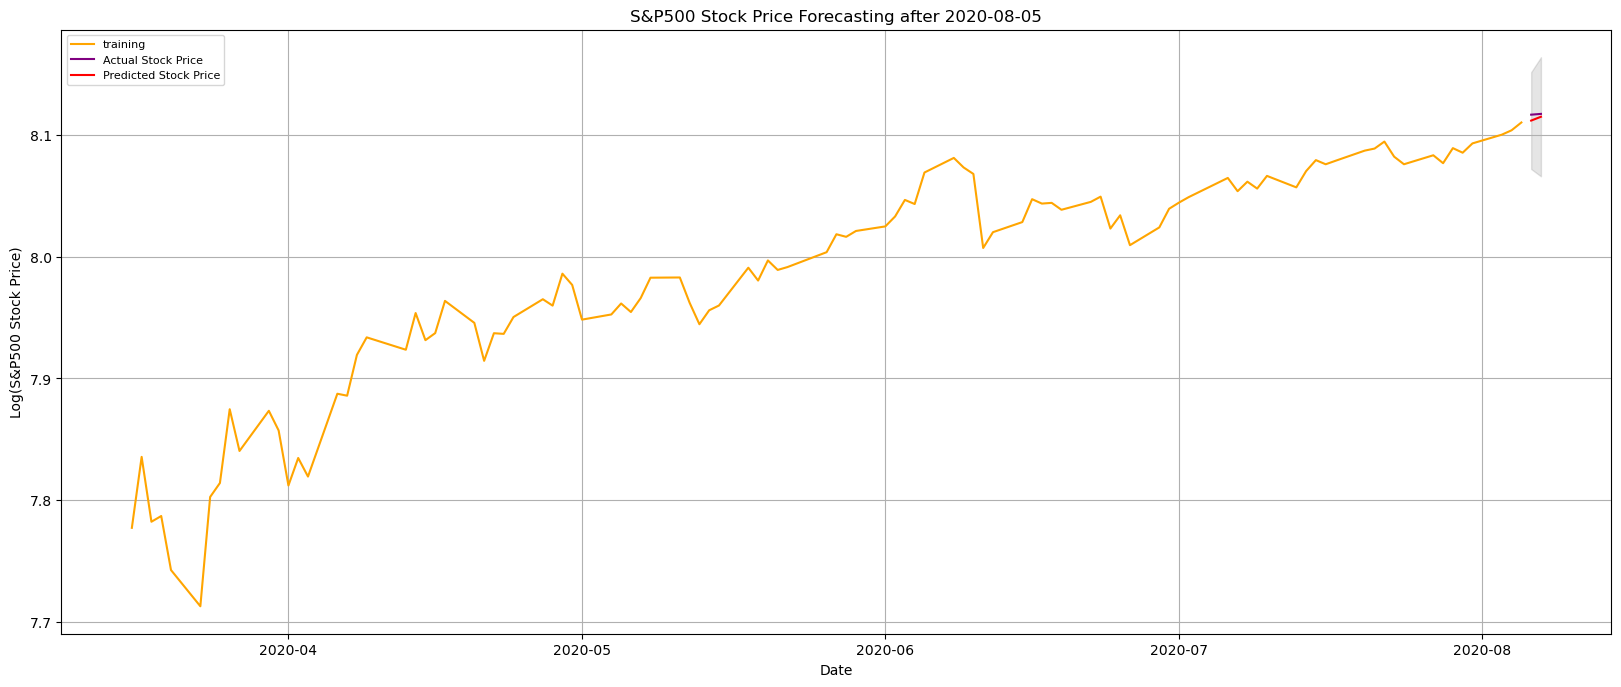

In [27]:
# Forecast
fc, se, conf = fitted.forecast(2, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
fc_series
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(20,8), dpi=100)
plt.grid(True)
plt.plot(train_data, label='training', color='orange')
plt.plot(test_data, color = 'purple', label='Actual Stock Price')
plt.plot(fc_series, color = 'red',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('S&P500 Stock Price Forecasting after 2020-08-05')
plt.xlabel('Date')
plt.ylabel('Log(S&P500 Stock Price)')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('S&P500_Stock_Price_Forecasting2.jpg')
plt.show()

In [28]:
df_nasdaq100.tail()

Date
2020-08-03    11055.08
2020-08-04    11096.54
2020-08-05    11125.44
2020-08-06    11267.08
2020-08-07    11139.39
Name: NASDAQ 100, dtype: float64

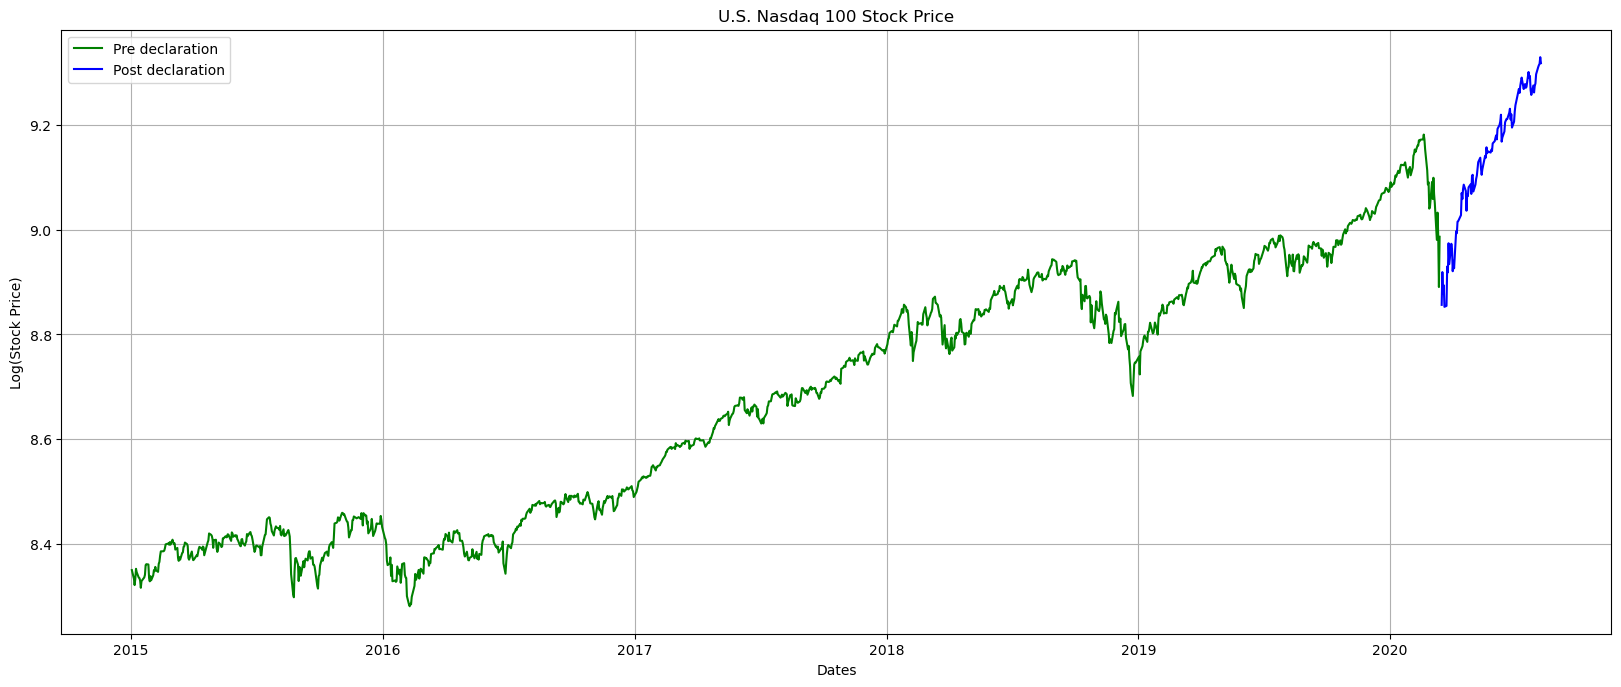

In [29]:
df_log = np.log(df_nasdaq100)
#split data into train and training set
train_data, test_data = df_log['2015-01-02':'2020-03-13'], df_log['2020-03-14':'2020-08-07']
#train_data.tail()
#test_data.head()
plt.figure(figsize=(20,8), dpi=100)
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Log(Stock Price)')
plt.title('U.S. Nasdaq 100 Stock Price')
plt.plot(train_data, 'green', label='Pre declaration')
plt.plot(test_data, 'blue', label='Post declaration')
plt.legend()

In [30]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7836.619, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7843.948, Time=0.44 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7845.007, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7836.486, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7843.478, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7846.111, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-7857.009, Time=1.50 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-7851.482, Time=0.61 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-7848.805, Time=0.95 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-7848.474, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-7852.771, Time=1.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-7847.023, Time=0.76 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-7848.907, Time=0.32 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 7.357 seconds
         

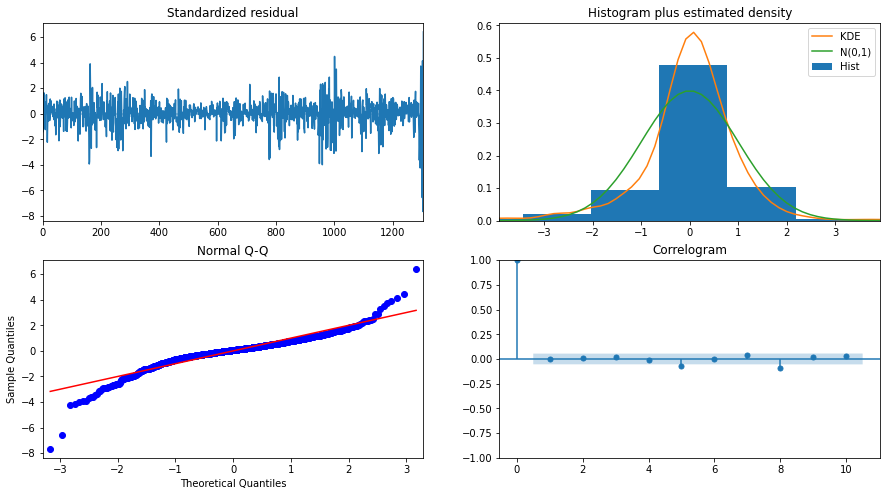

In [31]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [32]:
model = ARIMA(train_data, order=(3, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

/Users/xllz/anaconda3/envs/pyadv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xllz/anaconda3/envs/pyadv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D.NASDAQ 100   No. Observations:                 1307
Model:                 ARIMA(3, 1, 2)   Log Likelihood                3937.165
Method:                       css-mle   S.D. of innovations              0.012
Date:                Sat, 15 Aug 2020   AIC                          -7860.330
Time:                        11:13:43   BIC                          -7824.102
Sample:                             1   HQIC                         -7846.741
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0005      0.000      1.591      0.112      -0.000       0.001
ar.L1.D.NASDAQ 100    -0.6611      0.166     -3.991      0.000      -0.986      -0.336
ar.L2.D.NASDAQ 100  

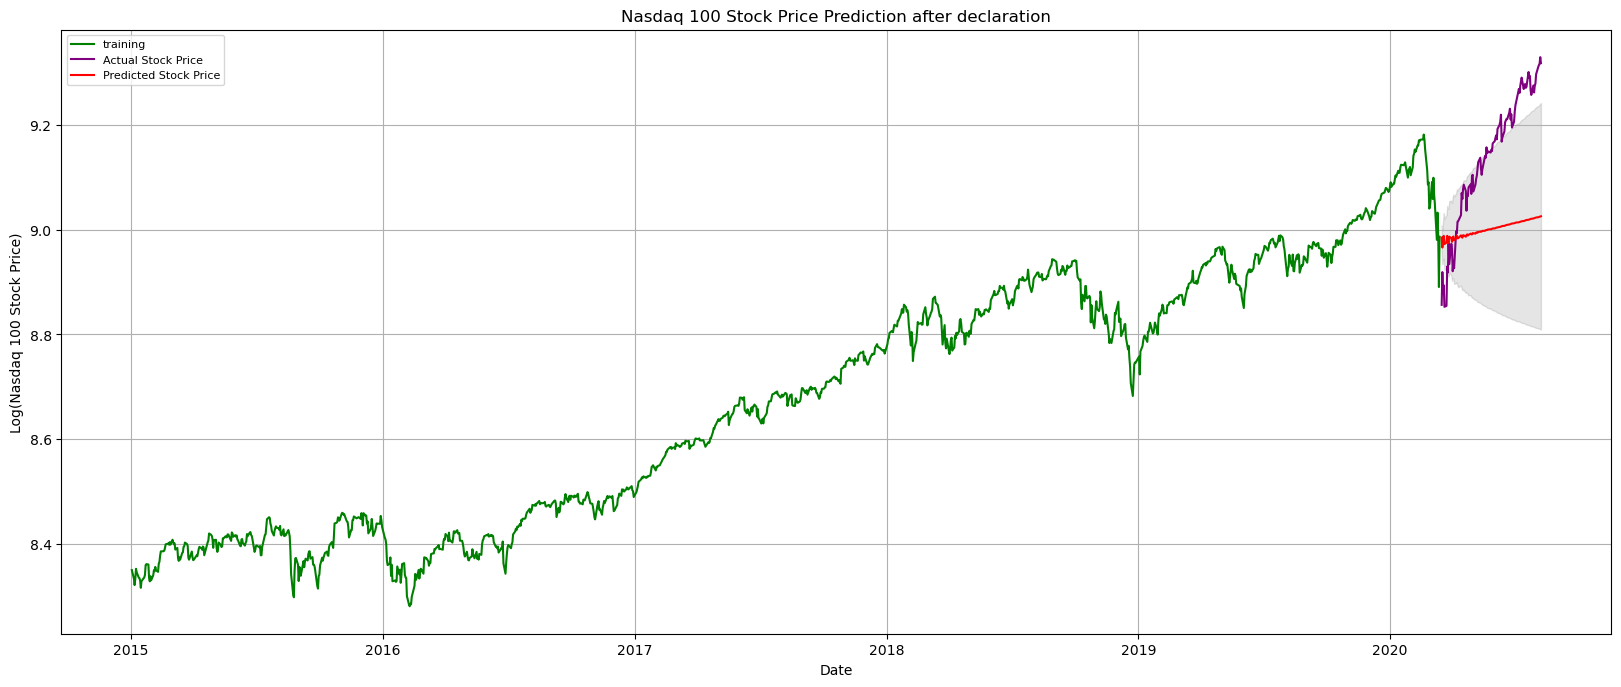

In [33]:
# Forecast
fc, se, conf = fitted.forecast(102, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
fc_series
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(20,8), dpi=100)
plt.grid(True)
plt.plot(train_data, label='training', color='green')
plt.plot(test_data, color = 'purple', label='Actual Stock Price')
plt.plot(fc_series, color = 'red',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Nasdaq 100 Stock Price Prediction after declaration')
plt.xlabel('Date')
plt.ylabel('Log(Nasdaq 100 Stock Price)')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('Nasdaq 100_Stock_Price_Forecasting1.jpg')
plt.show()

In [34]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.03162662218771531
MAE: 0.15802394162127467
RMSE: 0.17783875333491098
MAPE: 0.017182624546471226


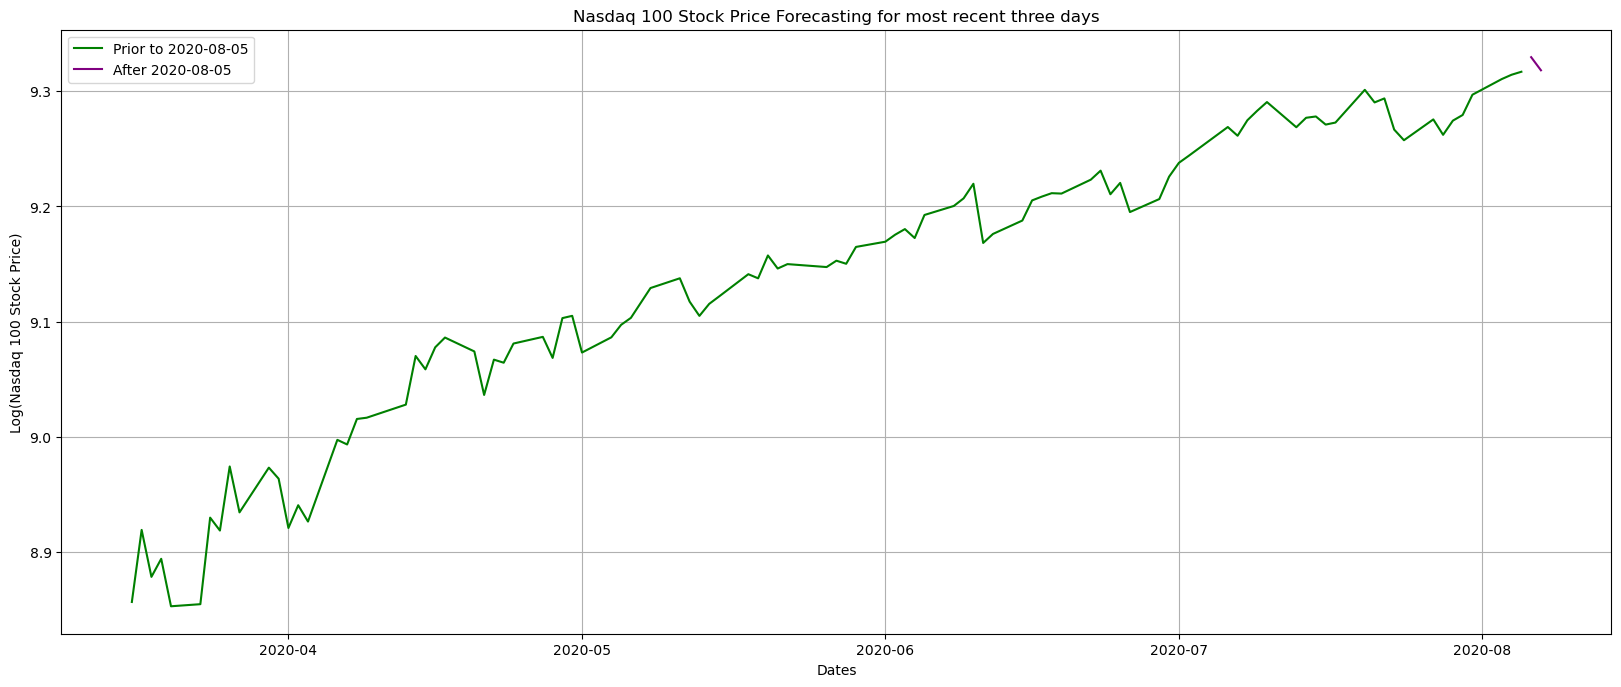

In [35]:
#split data into train and training set
df_log = np.log(df_nasdaq100)
#print(df_log)
train_data, test_data = df_log['2020-03-14':'2020-08-05'], df_log['2020-08-06':'2020-08-07']
# train_data.tail()
# test_data.tail()
plt.figure(figsize=(20,8), dpi=100)
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Log(Nasdaq 100 Stock Price)')
plt.title('Nasdaq 100 Stock Price Forecasting for most recent three days')
plt.plot(train_data, 'green', label='Prior to 2020-08-05')
plt.plot(test_data, 'purple', label='After 2020-08-05')
plt.legend()

In [36]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-473.767, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-486.051, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-485.239, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-471.308, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-484.186, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-484.236, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-486.335, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-486.693, Time=0.29 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-483.090, Time=0.30 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-484.481, Time=0.43 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-481.706, Time=0.39 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-474.978, Time=0.11 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 2.373 seconds
                               SARIMAX Results                                
Dep. Vari

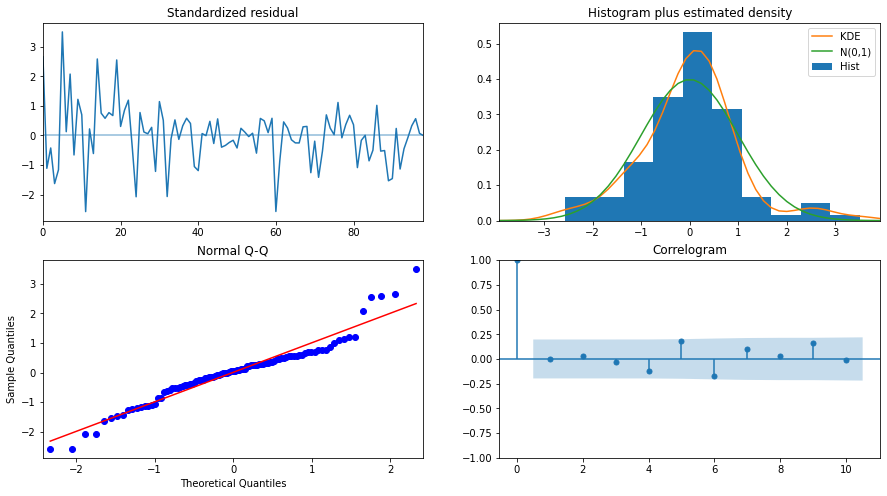

In [37]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [38]:
model = ARIMA(train_data, order=(3, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

/Users/xllz/anaconda3/envs/pyadv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xllz/anaconda3/envs/pyadv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D.NASDAQ 100   No. Observations:                   99
Model:                 ARIMA(3, 1, 1)   Log Likelihood                 249.362
Method:                       css-mle   S.D. of innovations              0.019
Date:                Sat, 15 Aug 2020   AIC                           -486.725
Time:                        11:13:48   BIC                           -471.154
Sample:                             1   HQIC                          -480.425
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0044      0.001      5.308      0.000       0.003       0.006
ar.L1.D.NASDAQ 100     0.3127      0.166      1.888      0.059      -0.012       0.637
ar.L2.D.NASDAQ 100  

In [ ]:
# Forecast
fc, se, conf = fitted.forecast(2, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
fc_series
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(20,8), dpi=100)
plt.grid(True)
plt.plot(train_data, label='training', color='orange')
plt.plot(test_data, color = 'purple', label='Actual Stock Price')
plt.plot(fc_series, color = 'red',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Nasdaq 100 Stock Price Forecasting after 2020-08-05')
plt.xlabel('Date')
plt.ylabel('Log(Nasdaq 100 Stock Price)')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('Nasdaq 100_Stock_Price_Forecasting2.jpg')
plt.show()